# Model Building - Predicting Departure Delays

Now that we have a continuous source of data that is labeled, we can attempt to

> Build a model that **predicts the probability of a departing flight delaying**

Our attempt will use an XGBoost classification model, given the amount of data we have, and the features that we will using, it seems like it's can bring the highest predictive power with a relatively lower amount of effort. 

In this notebook, we will:
- Clearly define what our problem is and setup evaluation metrics
- Load in data from BigQuery and clean out anomalies
- Build a model with XGBoost
- Evaluate the model against our evaluation metrics
- Tune the model to reach a statisfactory threshold for metrics

Once these are completed, the model can be saved into a repository (manual) and used for predictions for upcoming flights. This will be done in ```predict.ipynb```.

In [1]:
# Google modules for reading the from BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix


import pickle
from datetime import datetime, date

c:\Users\yoshi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\yoshi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\yoshi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Defining the Problem

It's clear that we're trying to predict if a departing flight will be delayed, but **what counts as being *delayed***? According to the Federal Aviation Administration:

> A flight is delayed when it is **15 minutes later** than its scheduled time

We'll go with this definition, presuming that when there are costs involved with flight delays,airlines will go with this official definition. 


## Building a Hypothesis - What are the features we should use?
So what are the features we will be using? Based on [previous studies](https://www.mdpi.com/2226-4310/8/8/212) from College of Civil Aviation, Nanjing University of Aeronautics and Astronautics [1], it seems as though the delays are largely impacted by **arrival delays from previous flights.** Other features I came up with, and weighing the extra time/costs involved in data collection, I have decided in using the following features:

|   Field   |   Description             |
|-----------|---------------            |
|dep_hour     |Hour of departure          |
|dep_weekday  |Day of week for departure  |
|prev_arr_hour|Hour of arrival of previous flight|
|prev_arr_weekday|Day of week of previous flight|
|scheduled_turnaround|Minutes between scheduled arrival and scheduled departure|
|arrival_delay|Minutes between scheduled arrival and actual arrival|
|destination|Country id of arrival|
|cargo|Boolean for whether it is a cargo flight|
|iata|IATA code of airline|
|fleet_size| Number of fleets the airline owns|
|route_flight_options|Number of unique flight numbers of same type with the same route on the same day|
|route_airline_options|Number of unique airlines with the same route on the same day|
|delayed | Boolean response variable|

Important to note that we define

> The previous arrival flight is the last flight of the same type(cargo/PAX), same lane, same airline that, arrived no farther than one week before scheduled departure and no earlier than [30 minutes before scheduled departure](http://aviationavi.com/turn-around-time-tat/#:~:text=The%20duration%20of%20the%20turnaround,is%20usually%20about%20an%20hour).

Which meant that the fields with previous arrival flights could very much be null if there isn't a corresponding flight. Such a defintion sits on the assumption that

> Flights are only bidirectional, that a flight from A->B would *only* return the same way from B->A.

In reality this may not always be the case, but in our study if a flight could not be found, it will be mapped to null, which the model could also weigh in on potentially. 

<img src="https://www.mdpi.com/aerospace/aerospace-08-00212/article_deploy/html/images/aerospace-08-00212-g001-550.jpg">

(Image directly from Zheng, 2021)

[1] *Zheng, Zhe, Wenbin Wei, and Minghua Hu. 2021. "A Comparative Analysis of Delay Propagation on Departure and Arrival Flights for a Chinese Case Study" Aerospace 8, no. 8: 212. https://doi.org/10.3390/aerospace8080212*

## Extracting Data - And observations...

Now that we have a collection of data in BigQuery, the data is **stitched together with SQL** first in a view set in BigQuery. This will mean we can forgo the majority of data combination, and focus more on cleaning what's on hand and training the model with.


In [2]:
# Set up bigquery selection
key_path = r"./bq_key.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [3]:
df = client.query("""
                        SELECT * FROM flights.training_main
                        """).to_dataframe()

df.sample(5).T #Easier to see transposed

,14445,13908,6507,1039,15285
prev_arr_hour,<NA>,<NA>,4,20,0
prev_arr_weekday,<NA>,<NA>,2,1,4
dep_hour,19,19,7,15,15
dep_weekday,4,2,2,4,4
scheduled_turnaround,<NA>,<NA>,150,3990,905
arrival_delay,<NA>,<NA>,445,982,-21
destination,ANC,YYZ,DXB,MNL,KIX
iata,7L,CX,EK,RH,LD
fleet_size,12,173,267,5,14
cargo,1,0,1,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21433 entries, 0 to 21432
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   prev_arr_hour          15521 non-null  Int64 
 1   prev_arr_weekday       15521 non-null  Int64 
 2   dep_hour               21433 non-null  Int64 
 3   dep_weekday            21433 non-null  Int64 
 4   scheduled_turnaround   15521 non-null  Int64 
 5   arrival_delay          15521 non-null  Int64 
 6   destination            21433 non-null  object
 7   iata                   21427 non-null  object
 8   fleet_size             21427 non-null  Int64 
 9   cargo                  21433 non-null  Int64 
 10  route_flight_options   21433 non-null  Int64 
 11  route_airline_options  21433 non-null  Int64 
 12  delayed                21433 non-null  Int64 
dtypes: Int64(11), object(2)
memory usage: 2.4+ MB


df.co

In [5]:
# casting to float to allow for pd.describe() to work with np.nan more reliably
df[['arrival_delay', 'scheduled_turnaround', 'fleet_size']] = df[
                                                ['arrival_delay', 'scheduled_turnaround', 'fleet_size']
                                                ].astype(float)

In [6]:
# basic df summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prev_arr_hour,15521.0,10.360673,7.207889,0.0,4.0,10.0,16.0,23.0
prev_arr_weekday,15521.0,4.225694,2.023706,1.0,3.0,4.0,6.0,7.0
dep_hour,21433.0,12.125601,6.599675,0.0,7.0,12.0,18.0,23.0
dep_weekday,21433.0,4.147156,1.984870,1.0,3.0,4.0,6.0,7.0
scheduled_turnaround,15521.0,1491.527479,2077.854822,35.0,130.0,765.0,1855.0,10040.0
arrival_delay,15521.0,88.005219,309.537918,-1357.0,-19.0,2.0,49.0,7067.0
fleet_size,21427.0,123.180753,142.524560,1.0,14.0,91.0,173.0,1441.0
cargo,21433.0,0.731349,0.443268,0.0,0.0,1.0,1.0,1.0
route_flight_options,21433.0,11.945365,9.123390,1.0,4.0,10.0,19.0,44.0
route_airline_options,21433.0,5.341809,3.605913,1.0,2.0,5.0,8.0,16.0


In [7]:
# how many flights have a previous arrival flight?
df['prev_arr_hour'].notnull().value_counts()

True     15521
False     5912
Name: prev_arr_hour, dtype: int64

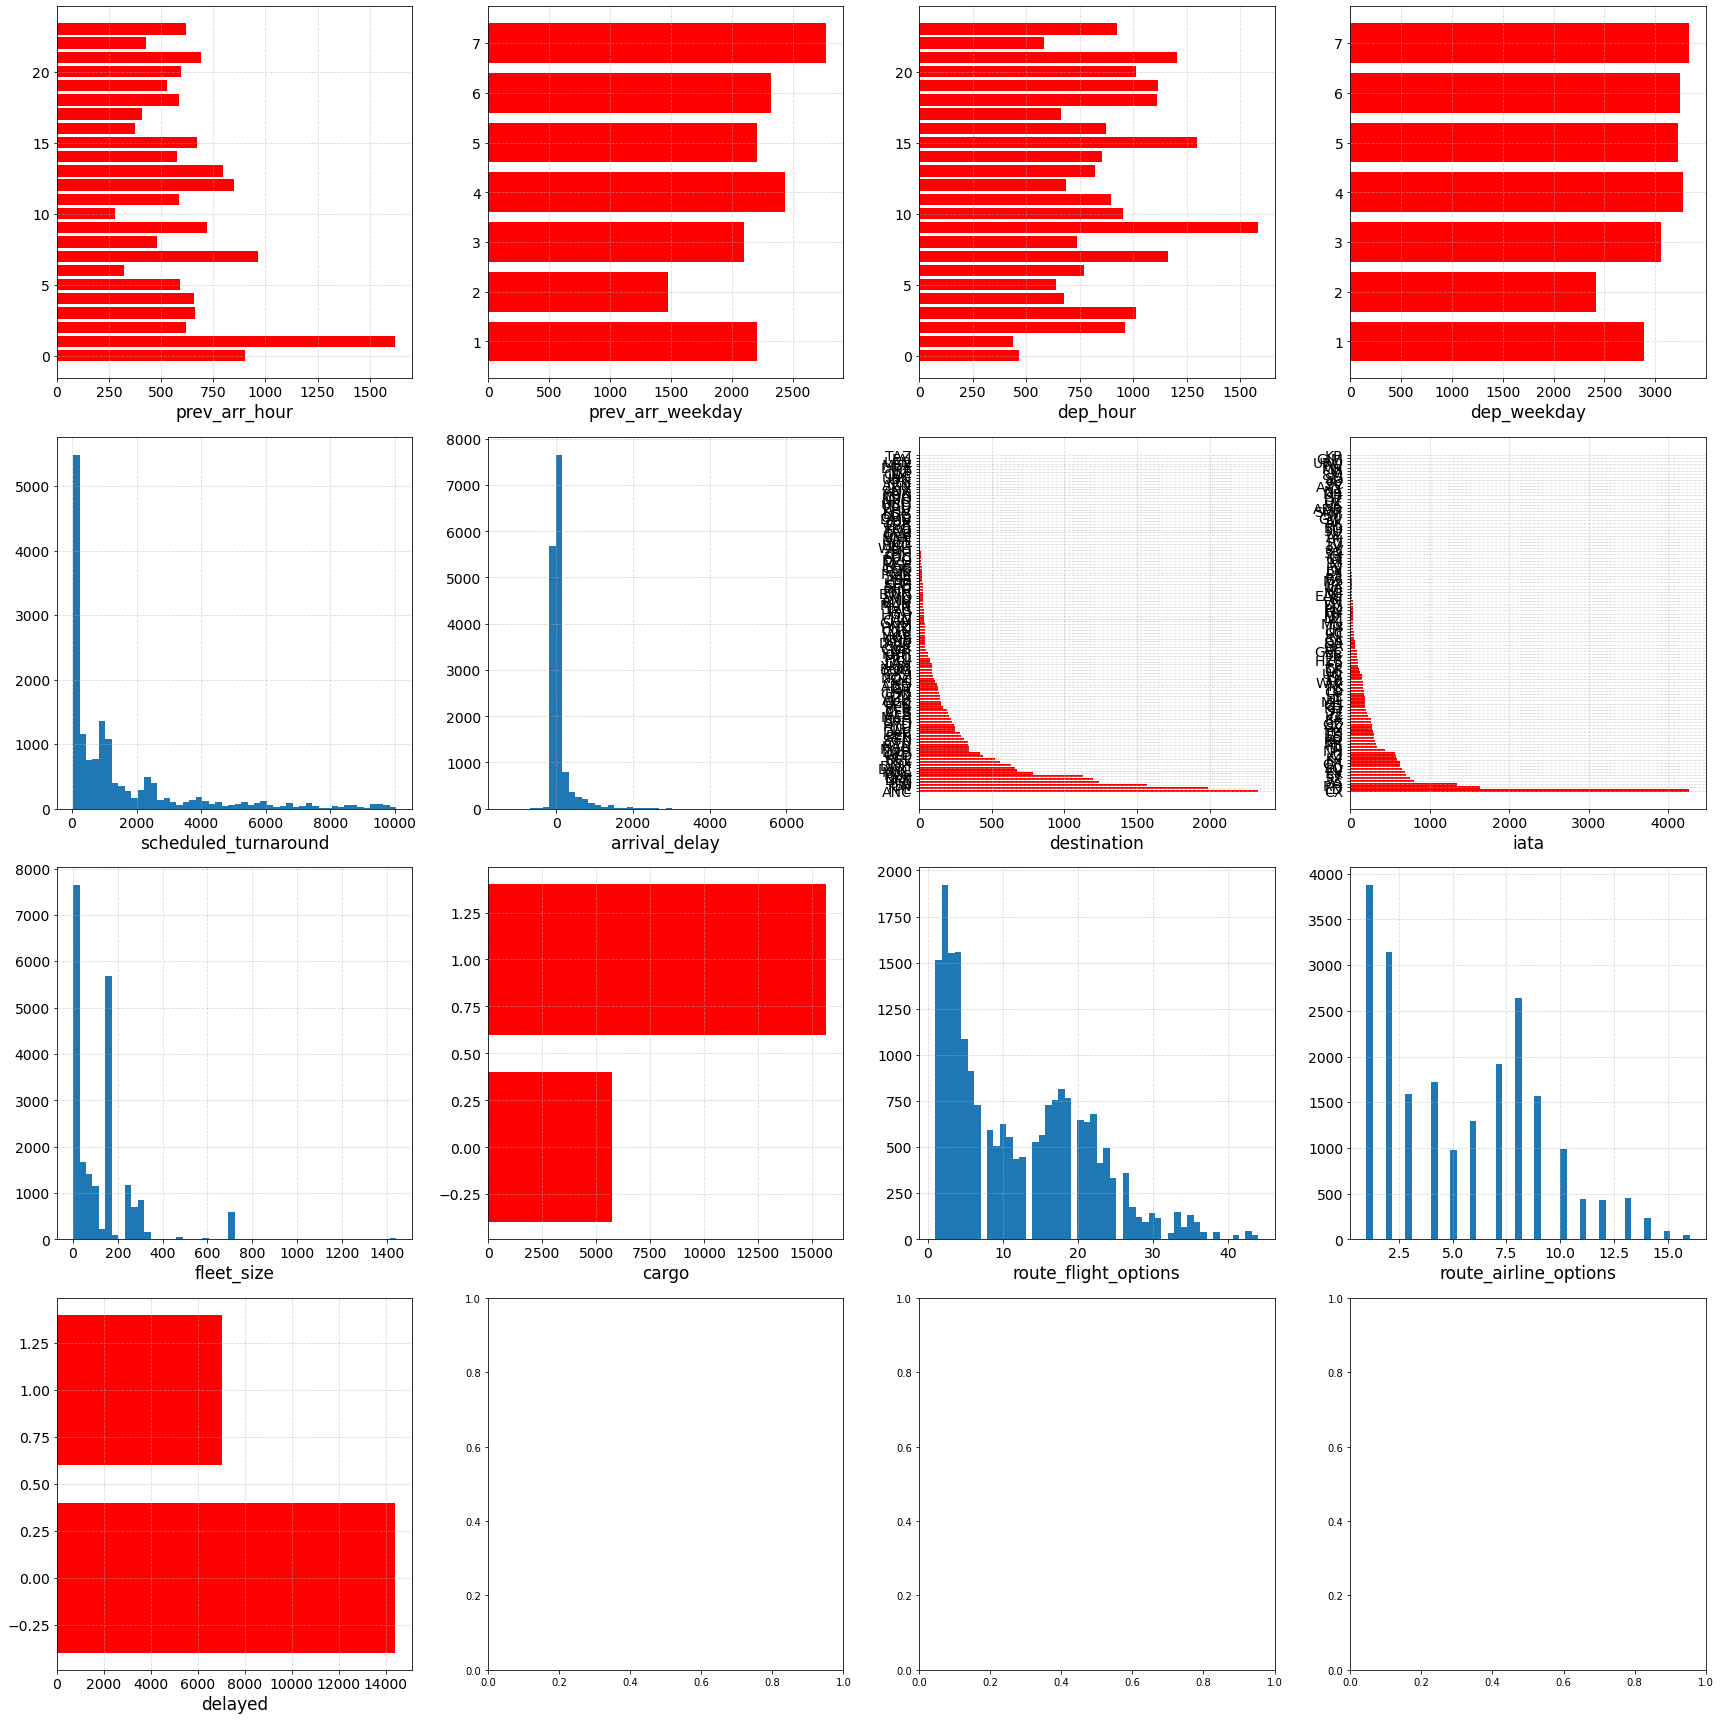

In [8]:
# Plotting the distributions of variables
attribute_number = len(df.columns)

# Attribute plot type
plot_type = {
    'prev_arr_hour':'bar_i', 'prev_arr_weekday':'bar_i', 'dep_hour':'bar_i', 'dep_weekday':'bar_i',
       'scheduled_turnaround':'hist', 'arrival_delay':'hist', 'destination':'bar', 'iata':'bar',
       'fleet_size':'hist', 'cargo':'bar_i', 'route_flight_options':'hist', 'route_airline_options':'hist',
       'delayed':'bar_i'
}

# subplots 
fig = plt.figure(figsize=(24, 24))
ax = fig.subplots(attribute_number//4+1,4)
# iterations
for num, title in enumerate(df.columns):
    idx = num//4 # divided with no remainder
    idy = num%4  # remainder 
    if plot_type[title] == 'bar':
        value_count_dict = df[title].value_counts().to_dict()
        keys = list(value_count_dict.keys())
        values = list(value_count_dict.values())
        ax[idx, idy].barh(keys, values, color='r')

    elif plot_type[title] == 'bar_i':
        value_count_dict = df[title].value_counts().to_dict()
        keys = list(value_count_dict.keys())
        values = list(value_count_dict.values())
        ax[idx, idy].barh(keys, values, color='r')

    else:
        ax[idx, idy].hist(df[title].values, bins=50);
    
    # set title with attribute
    ax[idx, idy].set_xlabel(title, fontsize=17)
    # set grid width
    ax[idx, idy].grid(linestyle='--', alpha=0.5)
    # font size of ticks
    ax[idx, idy].tick_params(labelsize=14)
plt.tight_layout()

The attributes *looks* well distributed **except for arrival_delay** i.e. it does not seem like there are anomalies present that are out of the ordinary. Though there are clearly skewness to the turnaround minutes, this is as expected and the distribution is bounded by a search domain of previous arrival belonging to ```[dep-7days, dep-30mins]```, a quasi business rule imposed.

Similar to what we did in our [EDA via R](https://github.com/yoshi-man/hkg-flights-study/blob/main/explore/flights_eda_notebook.nb.html), it may be beneficial to take away some of the extreme anomalies. In the grand scheme of model training, it shouldn't be too big of an issue, but is good to filter just in case.

In [9]:
# get quantiles for arrival_delay
first_quantile = np.quantile(df[df['arrival_delay'].notnull()]['arrival_delay'], 0.01)
second_quantile = np.quantile(df[df['arrival_delay'].notnull()]['arrival_delay'], 0.99)


print(f'Arrival Delay to filter for: {first_quantile} to {second_quantile}')
print(f'Original data shape: {df.shape}')
print(f"Filtered data shape: {df[((df['arrival_delay'] >= first_quantile) & (df['arrival_delay'] <= second_quantile)) | (df['arrival_delay'].isnull())].shape}")

df = df.drop(df[~(((df['arrival_delay'] >= first_quantile) & (df['arrival_delay'] <= second_quantile)) | (df['arrival_delay'].isnull()))].index)

Arrival Delay to filter for: -88.79999999999998 to 1457.0
Original data shape: (21433, 13)
Filtered data shape: (21124, 13)


count    15212.000000
mean        70.311925
std        210.861590
min        -88.000000
25%        -19.000000
50%          2.000000
75%         48.000000
max       1457.000000
Name: arrival_delay, dtype: float64


(array([7.600e+01, 1.570e+02, 6.380e+02, 1.613e+03, 2.882e+03, 2.675e+03,
        1.954e+03, 9.000e+02, 6.730e+02, 4.030e+02, 3.360e+02, 2.930e+02,
        2.260e+02, 1.790e+02, 1.320e+02, 1.150e+02, 1.290e+02, 1.410e+02,
        7.100e+01, 6.000e+01, 7.400e+01, 7.400e+01, 5.000e+01, 7.000e+01,
        5.400e+01, 5.200e+01, 2.700e+01, 3.300e+01, 5.400e+01, 3.500e+01,
        4.000e+01, 4.800e+01, 3.200e+01, 1.800e+01, 1.800e+01, 2.200e+01,
        2.600e+01, 4.300e+01, 2.500e+01, 1.600e+01, 2.600e+01, 1.500e+01,
        3.700e+01, 2.700e+01, 2.000e+01, 2.200e+01, 3.000e+01, 2.200e+01,
        2.000e+01, 2.000e+01, 4.200e+01, 1.000e+01, 2.000e+01, 2.100e+01,
        1.500e+01, 1.300e+01, 2.400e+01, 1.800e+01, 4.000e+00, 1.200e+01,
        1.600e+01, 9.000e+00, 5.000e+00, 1.300e+01, 1.300e+01, 9.000e+00,
        1.800e+01, 1.000e+01, 2.800e+01, 9.000e+00, 5.000e+00, 1.300e+01,
        5.000e+00, 7.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 1.400e+01,
        5.000e+00, 1.100e+01, 9.000e+0

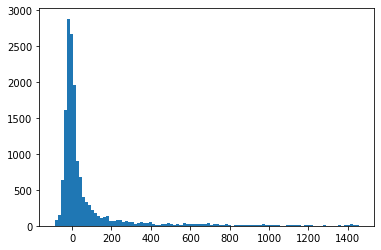

In [10]:
# Arrival delay now looks much less skewed
print(df.describe()['arrival_delay'])

plt.hist(df['arrival_delay'], bins=100)

## Building the Model - XGBoost

The process of building a model involves:

1. One-Hot Encode categorical features i.e. IATA and Destination, using ```sklearn.preprocessing```
2. Train-Val-Test split of data, using ```sklearn.preprocessing```
3. Setup Hyperparameters for XGBoost
4. Fit model based on AUC
5. Model Evaluation
6. Hyperparameters tuning with ```sklearn.model_selection.RandomSearchCV``` and ```sklearn.model_selection.GridSearchCV```
7. Save Model, Encoder via pickle

### One-Hot Encoding for IATA and Destination

Every training, we initialize a new encoder for IATA and destination. This will be used again during inference. The key is to have ```handle_unknown="ignore"``` to account for new destinations in unseen during training.

In [11]:
# Initialisse an Encoder
iata_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
iata_encoder.fit(np.array(df['iata']).reshape(-1, 1))

dest_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
dest_encoder.fit(np.array(df['destination']).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [12]:
# check in case it's not right
print(f"IATA Values:", iata_encoder.categories_[0][:5], "...")
print(f"Destination Values:",dest_encoder.categories_[0][:5], "...")

IATA Values: ['3D' '3S' '3U' '3V' '4B'] ...
Destination Values: ['AAN' 'ADD' 'AKL' 'ALA' 'AMS'] ...


In [13]:
# get encoded columns
iata_OHE = pd.DataFrame(iata_encoder.transform(np.array(df['iata']).reshape(-1, 1)))
iata_OHE.columns = [f'iata_{x}' for x in iata_OHE.columns]

dest_OHE = pd.DataFrame(dest_encoder.transform(np.array(df['destination']).reshape(-1, 1)))
dest_OHE.columns = [f'dest_{x}' for x in dest_OHE.columns]

In [14]:
data = pd.concat([df, iata_OHE, dest_OHE], axis=1
                ).drop(columns=['iata', 'destination']).fillna(np.nan)

print(f"Data Shape: {data.shape}")
data.head()

Data Shape: (21431, 239)


,prev_arr_hour,prev_arr_weekday,dep_hour,dep_weekday,scheduled_turnaround,arrival_delay,fleet_size,cargo,route_flight_options,route_airline_options,...,dest_108,dest_109,dest_110,dest_111,dest_112,dest_113,dest_114,dest_115,dest_116,dest_117
0,20,5,0,6,250.0,955.0,173.0,1,25,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,<NA>,<NA>,7,6,NaN,NaN,27.0,1,25,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,<NA>,<NA>,9,6,NaN,NaN,166.0,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,6,16,6,80.0,1122.0,5.0,1,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,7,16,6,8695.0,-10.0,55.0,1,25,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
data['arrival_delay'].isnull().value_counts()

False    15212
True      6219
Name: arrival_delay, dtype: int64

In [16]:
data['delayed'].isnull().value_counts()

False    21124
True       307
Name: delayed, dtype: int64

In [17]:
data = data[data['delayed'].notnull()]

### Setting Up Train-Val-Test Split

We will be splitting the data in 70%-15%-15%, a common split. The key here is to make sure we set ```stratify=y``` to ensure the same distribution for responses between the datasets.

In [18]:
X = data.astype(float).drop(columns = ['delayed']) 
y = data.astype(float)['delayed']

# split train-test by 70%-30%
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    shuffle=True, stratify=y)


# split val-test to 15%-15%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5,
                                                    shuffle=True, stratify=y_test)
                            

# using a DMatrix is better practice for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.NaN)
dval = xgb.DMatrix(X_val, label=y_val, missing=np.NaN)
dtest = xgb.DMatrix(X_test, label=y_test, missing=np.NaN)

print('X_train:  {} || y_train:  {} || positive_rate: {:.3f}'.format(
        X_train.shape, y_train.shape, np.sum(y_train)/len(y_train)))

print('X_val : {} || y_val: {} || positive_rate: {:.3f}'.format(
        X_val.shape, y_val.shape, np.sum(y_val)/len(y_val)))

print('X_test: {} || y_test: {} || positive_rate: {:.3f}'.format(
        X_test.shape, y_test.shape, np.sum(y_test)/len(y_test)))

X_train:  (14786, 238) || y_train:  (14786,) || positive_rate: 0.323
X_val : (3169, 238) || y_val: (3169,) || positive_rate: 0.323
X_test: (3169, 238) || y_test: (3169,) || positive_rate: 0.323


### Initial Training - Hyperparameters

Before we tune any hyperparameters, we can start off with a set of hyperparameters that are commonly used. Once we get a basic idea of accuracy, we can start tuning based the search methods.

In [19]:
param = {'max_depth': 8, 
        'eta': 0.12, 
        'objective': 'binary:logistic', 
        'lambda': 100, 
        'colsample_bytree': 0.75,
        'eval_metric': 'auc',
        'scale_pos_weight': 0.3,
        }

num_round = 1000
early_stopping_rounds = 50

In [20]:
bst = xgb.train(param, dtrain, num_round, 
                early_stopping_rounds=early_stopping_rounds,
                evals=[(dtrain, 'Train'), (dval, 'Valid')],
                verbose_eval=True)


[0]	Train-auc:0.50085	Valid-auc:0.50174
[1]	Train-auc:0.62524	Valid-auc:0.61092
[2]	Train-auc:0.63366	Valid-auc:0.61747
[3]	Train-auc:0.66664	Valid-auc:0.65602
[4]	Train-auc:0.67653	Valid-auc:0.66648
[5]	Train-auc:0.68024	Valid-auc:0.66954
[6]	Train-auc:0.77893	Valid-auc:0.76007
[7]	Train-auc:0.79094	Valid-auc:0.77358
[8]	Train-auc:0.79367	Valid-auc:0.77354
[9]	Train-auc:0.79840	Valid-auc:0.77890
[10]	Train-auc:0.80413	Valid-auc:0.78505
[11]	Train-auc:0.80791	Valid-auc:0.78744
[12]	Train-auc:0.81644	Valid-auc:0.79923
[13]	Train-auc:0.81965	Valid-auc:0.80172
[14]	Train-auc:0.82307	Valid-auc:0.80832
[15]	Train-auc:0.82425	Valid-auc:0.80835
[16]	Train-auc:0.82565	Valid-auc:0.80929
[17]	Train-auc:0.82604	Valid-auc:0.80902
[18]	Train-auc:0.82795	Valid-auc:0.81139
[19]	Train-auc:0.82962	Valid-auc:0.81406
[20]	Train-auc:0.83367	Valid-auc:0.81754
[21]	Train-auc:0.83574	Valid-auc:0.81825
[22]	Train-auc:0.84063	Valid-auc:0.82515
[23]	Train-auc:0.84198	Valid-auc:0.82663
[24]	Train-auc:0.84362	Val

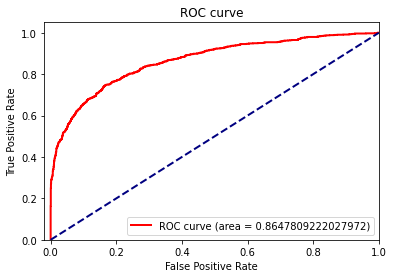

In [21]:
y_pred = bst.predict(dtest)

plt.figure()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='r',
            lw=lw, label=f'ROC curve (area = {roc_auc})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

We have a trained model with a fairly high level for Area Under Curve score. This model currently has 0.86 as the AUC of the ROC curve. These initial hyperparameters will serve as a good ballpark number for our next section of Hyperparameter tuning first with RandomSearchCV.

### Hyperparameter Tuning - RandomSearchCV

The approach we will be using RandomSearchCV to try out a larger range of values in case we spot any better values. 

> Once we've located the best hyperparameters from Random Search to try and catch an even more optimal level, we can use it to fit our new model with.

In [22]:
# set the hyperparameter range
params = {'max_depth': [4, 6, 8, 10, 12, 14, 16], 
        'eta': [0.05, 0.1, 0.2, 0.4], 
        'lambda': [0, 5, 10, 20, 40, 80, 160], 
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        }

xgbr = xgb.XGBRegressor(seed = 20)

clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='roc_auc',
                         n_iter=25,
                         verbose=1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_weight=None, seed=20,
                                          subsample=None, tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=25,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8],
                                        'eta': [0.05, 0.1, 0.2, 0.4],
                                        'lambda': [0, 5, 10, 20, 40, 80, 160],
                                        'max_depth': [4, 6, 8, 10, 12, 14, 16]},
                   scoring='roc_auc', verbose=1)

In [65]:
print("Best parameters:", clf.best_params_)
print("Highest AUC: ", clf.best_score_)

Best parameters: {'max_depth': 8, 'lambda': 20, 'eta': 0.1, 'colsample_bytree': 0.6}
Highest AUC:  0.8588672175622609


Using the new hyperparameters as found from Random Search, we can build the final model with the best performance based on AUC.

In [23]:
param = {'max_depth': clf.best_params_['max_depth'], 
        'eta': clf.best_params_['eta'], 
        'objective': 'binary:logistic', 
        'lambda': clf.best_params_['lambda'], 
        'colsample_bytree': clf.best_params_['colsample_bytree'],
        'eval_metric': 'auc',
        'scale_pos_weight': np.sum(y)/len(y),
        }

num_round = 1000
early_stopping_rounds = 50

bst = xgb.train(param, dtrain, num_round, 
                early_stopping_rounds=early_stopping_rounds,
                evals=[(dtrain, 'Train'), (dval, 'Valid')],
                verbose_eval=True)

[0]	Train-auc:0.56910	Valid-auc:0.57257
[1]	Train-auc:0.78448	Valid-auc:0.77234
[2]	Train-auc:0.79552	Valid-auc:0.78015
[3]	Train-auc:0.79608	Valid-auc:0.77990
[4]	Train-auc:0.79555	Valid-auc:0.77899
[5]	Train-auc:0.81132	Valid-auc:0.80140
[6]	Train-auc:0.81388	Valid-auc:0.80348
[7]	Train-auc:0.80872	Valid-auc:0.79404
[8]	Train-auc:0.81980	Valid-auc:0.80786
[9]	Train-auc:0.82054	Valid-auc:0.80836
[10]	Train-auc:0.82105	Valid-auc:0.80814
[11]	Train-auc:0.82142	Valid-auc:0.80850
[12]	Train-auc:0.82240	Valid-auc:0.80798
[13]	Train-auc:0.82304	Valid-auc:0.80866
[14]	Train-auc:0.82291	Valid-auc:0.80790
[15]	Train-auc:0.82312	Valid-auc:0.80757
[16]	Train-auc:0.82335	Valid-auc:0.80767
[17]	Train-auc:0.82596	Valid-auc:0.81127
[18]	Train-auc:0.83063	Valid-auc:0.81662
[19]	Train-auc:0.83178	Valid-auc:0.81692
[20]	Train-auc:0.83249	Valid-auc:0.81687
[21]	Train-auc:0.83272	Valid-auc:0.81723
[22]	Train-auc:0.83368	Valid-auc:0.81687
[23]	Train-auc:0.83420	Valid-auc:0.81678
[24]	Train-auc:0.83503	Val

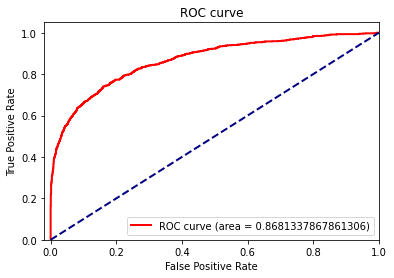

In [24]:
y_pred = bst.predict(dtest)

plt.figure()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='r',
            lw=lw, label=f'ROC curve (area = {roc_auc})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

### Setting the Right Threshold

As we have an unbalanced binary class for our delayed response, using 0.5 as the threshold will be problematic when we begin to consider metrics such as precision and recall. To better address this and balance out precision and recall, it will be beneficial to use the F1-Score:

$$ F_1 = 2 \frac{precision * recall}{precision+recall} $$


In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

beta = 1

f_score = (1 + beta**2)*precision*recall/(beta**2*precision + recall)
ix = np.argmax(f_score) #get threshold with highest F-score

y_pred_labels = list(np.where(np.array(y_pred) > thresholds[ix], 1, 0))

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f_score[ix]))
print(confusion_matrix(y_test, y_pred_labels))


Best Threshold=0.154488, F-Score=0.713
[[1800  345]
 [ 266  758]]


### Saving the Model to be Used

The components we will be needing to pickle save will be the model itself and the encoders. This makes way for future need to do predictions. Ofcourse, the metrics calculations will be the same as well. More importantly, we also need to make sure we **keep track of the threshold that maximises our F1 score**. The way we do this can just be by the model file name.

In [26]:
model_name = f"{date.today().strftime('%Y%m%d')}_t_{thresholds[ix]}".replace(".", "_")
iata_encoder_name = f"{date.today().strftime('%Y%m%d')}_iata_encoder"
dest_encoder_name = f"{date.today().strftime('%Y%m%d')}_dest_encoder"

pickle.dump(bst, open(f'./models/{model_name}.pkl', "wb"))
pickle.dump(iata_encoder, open(f'./models/{iata_encoder_name}.pkl', "wb"))
pickle.dump(dest_encoder, open(f'./models/{dest_encoder_name}.pkl', "wb"))